In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Define source and destination paths
source_path = '/content/drive/MyDrive/data/Final Project /Data.zip'
destination_path = '/content/Data.zip'

# Copy the file
shutil.copy(source_path, destination_path)

print(f'File copied from {source_path} to {destination_path}')

File copied from /content/drive/MyDrive/data/Final Project /Data.zip to /content/Data.zip


In [ ]:
!unzip '/content/Data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Mobile-Phones/Samsung/1638064507831_Samsung Galaxy M21 Used for sale.jpg  
  inflating: Mobile-Phones/Samsung/1639531631924_Samsung Galaxy S9 64GB Used for sale.jpg  
  inflating: Mobile-Phones/Samsung/1636400144518_Samsung Galaxy A50 4GB 64GB New for sale.jpg  
  inflating: Mobile-Phones/Samsung/1636620837963_Samsung Galaxy S20FE 128GB Used for sale.jpg  
  inflating: Mobile-Phones/Samsung/1636615987614_Samsung Galaxy J1 Nxt Used for sale.jpg  
  inflating: Mobile-Phones/Samsung/1638060537529_Samsung Galaxy A10s Used for sale.jpg  
  inflating: Mobile-Phones/Samsung/1638392677016_Samsung Galaxy S8 64GB Used for sale.jpg  
  inflating: Mobile-Phones/Samsung/1639537047435_Samsung Galaxy A03s 464 New for sale.jpg  
  inflating: Mobile-Phones/Samsung/1636628296851_Samsung Galaxy A51 128GB New for sale.jpg  
  inflating: Mobile-Phones/Samsung/1635054024017_Samsung Galaxy J7 SMJ700F Used for sale.jpg  
  inflating: Mobile-Phone

In [ ]:
import os
from PIL import Image

# Paths to the Soda Drinks directories
Samsung_dir = '/content/Mobile-Phones/Samsung'
iPhone_dir = '/content/Mobile-Phones/Apple'


# Initialize variables to store information
file_extensions = {'Samsung': [], 'iPhone': []}
image_shapes = {'Samsung': [], 'iPhone': []}
image_sizes = {'Samsung': [], 'iPhone': []}

# Function to explore images in a directory
def explore_images(directory, label):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            with Image.open(file_path) as img:
                # Get file extension
                ext = filename.split('.')[-1].lower()
                file_extensions[label].append(ext)

                # Get image shape
                shape = img.size  # (width, height)
                image_shapes[label].append(shape)

                # Get image size in bytes
                size = os.path.getsize(file_path)
                image_sizes[label].append(size)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

# Explore T-Shirt images
explore_images(Samsung_dir, 'Samsung')
explore_images(iPhone_dir, 'iPhone')


# Display the results
print(f"Samsung Image Extensions: {set(file_extensions['Samsung'])}")
print(f"iPhone Image Extensions: {set(file_extensions['iPhone'])}")

print(f"Samsung Image Shapes: {set(image_shapes['Samsung'])}")
print(f"iPhone Image Shapes: {set(image_shapes['iPhone'])}")


print(f"Samsung Image Sizes (min, max): {min(image_sizes['Samsung'])} bytes, {max(image_sizes['Samsung'])} bytes")
print(f"iPhone Image Sizes (min, max): {min(image_sizes['iPhone'])} bytes, {max(image_sizes['iPhone'])} bytes")


Samsung Image Extensions: {'jpg'}
iPhone Image Extensions: {'jpg'}
Samsung Image Shapes: {(160, 120), (142, 107)}
iPhone Image Shapes: {(160, 120), (142, 107)}
Samsung Image Sizes (min, max): 657 bytes, 9413 bytes
iPhone Image Sizes (min, max): 823 bytes, 8554 bytes


In [ ]:
# Count the number of images in each class
num_Samsung_images = len(os.listdir(Samsung_dir))
num_iPhone_images = len(os.listdir(iPhone_dir))

# Print the results
num_Samsung_images, num_iPhone_images

(15498, 26955)

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image

# Define dataset path
data_dir = '/content/Mobile-Phones'


def convert_to_rgb(image):
    """
    Converts 'P' mode images with transparency to 'RGBA', and then to 'RGB'.
    This is to avoid transparency issues during model training.
    """
    if image.mode in ('P', 'RGBA'):
        return image.convert('RGB')
    return image

# Update the transformations for both training and validation
train_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # Convert to RGB
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Augmentation: randomly flip images
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # Convert to RGB
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])


# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

In [ ]:
# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply validation transforms to validation set
val_dataset.dataset.transform = val_transform

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [ ]:
# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the last layer to match the number of classes (2 classes: pants, T-shirt)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


In [ ]:
# Training and validation loop
epochs = 10
best_val_acc = 0.0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_val_acc:.4f}')


Epoch 1/10
Train Loss: 0.3044 Acc: 0.8600
Val Loss: 0.2620 Acc: 0.8607

Classification Report:
              precision    recall  f1-score   support

       Apple       0.84      0.97      0.90      5366
     Samsung       0.93      0.67      0.78      3125

    accuracy                           0.86      8491
   macro avg       0.88      0.82      0.84      8491
weighted avg       0.87      0.86      0.85      8491

Epoch 2/10
Train Loss: 0.1520 Acc: 0.9303
Val Loss: 0.2150 Acc: 0.9022

Classification Report:
              precision    recall  f1-score   support

       Apple       0.90      0.95      0.92      5366
     Samsung       0.91      0.82      0.86      3125

    accuracy                           0.90      8491
   macro avg       0.90      0.88      0.89      8491
weighted avg       0.90      0.90      0.90      8491

Epoch 3/10
Train Loss: 0.1116 Acc: 0.9513
Val Loss: 0.1891 Acc: 0.9163

Classification Report:
              precision    recall  f1-score   support

      

In [ ]:
import shutil

# Define source and destination paths
source_path = '/content/best_model.pth'
destination_path = '/content/drive/MyDrive/data/Final Project /Phone_best_model.pth'

# Copy the file
shutil.copy(source_path, destination_path)

print(f'File copied from {source_path} to {destination_path}')

File copied from /content/best_model.pth to /content/drive/MyDrive/data/Final Project /Phone_best_model.pth


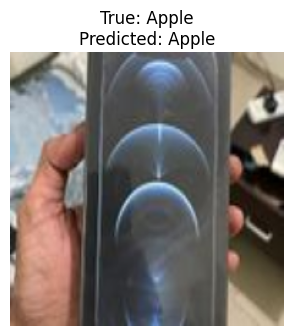

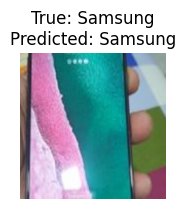

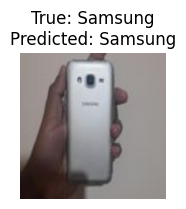

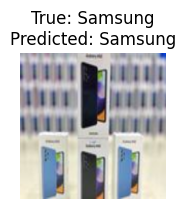

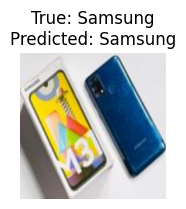

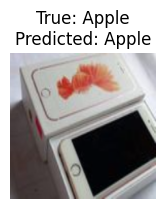

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display image along with the title
def imshow(image, title=None):
    """Display an image tensor."""
    # Undo the normalization (reverse mean and std)
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axis
    plt.pause(0.001)  # Pause for a short time so the plot updates

# Function to show random images along with true and predicted labels
def show_random_prediction():
    model.eval()  # Set the model to evaluation mode

    # Load one random batch from validation data
    inputs, labels = next(iter(val_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # Move inputs, labels, and predictions back to CPU for visualization
    inputs = inputs.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Display multiple images along with their predictions
    plt.figure(figsize=(12, 12))

    # Show 6 random images from the batch
    for i in range(6):  # Showing 6 images
        rand_idx = np.random.randint(0, len(inputs))  # Pick a random index

        plt.subplot(2, 3, i+1)  # Create a 2x3 grid of images

        imshow(inputs[rand_idx],
               title=f"True: {dataset.classes[labels[rand_idx]]}\nPredicted: {dataset.classes[preds[rand_idx]]}")

    plt.show()

# Call the function to show random predictions
show_random_prediction()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# code to use saving model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes
model.load_state_dict(torch.load('/content/drive/MyDrive/data/Final Project /Phone_best_model.pth'))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-055d5883bec2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

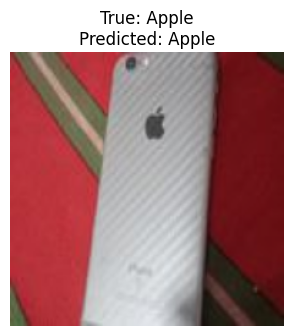

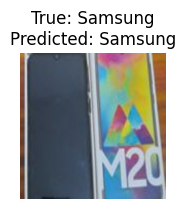

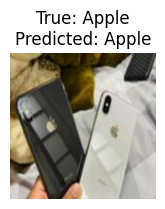

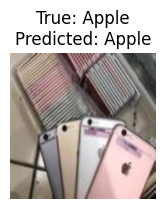

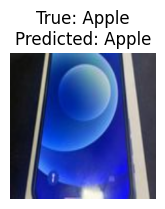

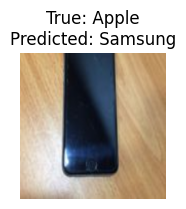

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display image along with the title
def imshow(image, title=None):
    """Display an image tensor."""
    # Undo the normalization (reverse mean and std)
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axis
    plt.pause(0.001)  # Pause for a short time so the plot updates

# Function to show random images along with true and predicted labels
def show_random_prediction():
    model.eval()  # Set the model to evaluation mode

    # Load one random batch from validation data
    inputs, labels = next(iter(val_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # Move inputs, labels, and predictions back to CPU for visualization
    inputs = inputs.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Display multiple images along with their predictions
    plt.figure(figsize=(12, 12))

    # Show 6 random images from the batch
    for i in range(6):  # Showing 6 images
        rand_idx = np.random.randint(0, len(inputs))  # Pick a random index

        plt.subplot(2, 3, i+1)  # Create a 2x3 grid of images

        imshow(inputs[rand_idx],
               title=f"True: {dataset.classes[labels[rand_idx]]}\nPredicted: {dataset.classes[preds[rand_idx]]}")

    plt.show()

# Call the function to show random predictions
show_random_prediction()


In [ ]:
##Stop:
